# Time Series Cross Validation

In [1]:
import pandas as pd
import numpy as np

Up till now we have used a single validation period to select our best model.  The weakness of that approach is that it gives you a sample size of 1 (that's better than nothing, but generally poor statistics!).  Time series cross validation is an approach to provide more data points when comparing models. In the classicial time series literature time series cross validation is called a **Rolling Forecast Origin**.  There may also be benefit of taking a **sliding window** approach to cross validaiton.  This second approach maintains a fixed sized training set.  I.e. it drops older values from the time series during validation.

## Rolling Forecast Origin

The following code and output provide a simplified view of how rolling forecast horizons work in practice.

In [2]:
def rolling_forecast_origin(train, min_train_size, horizon):
    '''
    Rolling forecast origin generator.
    '''
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_val

In [3]:
full_series = [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222, 1234, 3456]

test = full_series[-2:]
train = full_series[:-2]
print('full training set: {0}'.format(train))
print('hidden test set: {0}'.format(test))

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]
hidden test set: [1234, 3456]


In [6]:
cv_rolling = rolling_forecast_origin(train, min_train_size=4, horizon=2)
cv_rolling

<generator object rolling_forecast_origin at 0x1208a78b8>

In [7]:
i = 0
for cv_train, cv_val in cv_rolling:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

CV[1]
Train:	[2502, 2414, 2800, 2143]
Val:	[2708, 1900]
-----
CV[2]
Train:	[2502, 2414, 2800, 2143, 2708]
Val:	[1900, 2333]
-----
CV[3]
Train:	[2502, 2414, 2800, 2143, 2708, 1900]
Val:	[2333, 2222]
-----


## Sliding Window Cross Validation

In [8]:
def sliding_window(train, window_size, horizon):
    '''
    sliding window  generator.
    '''
    for i in range(len(train) - window_size - horizon + 1):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size:window_size+i+horizon]
        yield split_train, split_val

In [9]:
cv_sliding = sliding_window(train, window_size=4, horizon=1)

print('full training set: {0}\n'.format(train))

i = 0
for cv_train, cv_val in cv_sliding:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]

CV[1]
Train:	[2502, 2414, 2800, 2143]
Val:	[2708]
-----
CV[2]
Train:	[2414, 2800, 2143, 2708]
Val:	[1900]
-----
CV[3]
Train:	[2800, 2143, 2708, 1900]
Val:	[2333]
-----
CV[4]
Train:	[2143, 2708, 1900, 2333]
Val:	[2222]
-----


## Cross validation example

In [10]:
def cross_validation_score(model, train, cv, metric):
    '''
    Calculate cross validation scores
    '''
    cv_scores = []
    for cv_train, cv_test in cv:
        model.fit(cv_train)
        preds = model.predict(horizon=len(cv_test))
        score=metric(y_true=cv_test, y_pred=preds)
        cv_scores.append(score)
    return np.array(cv_scores)

In [11]:
from forecast.baseline import SNaive, Naive1
from sklearn.metrics import mean_absolute_error

In [12]:
#load the ED attendance dataset
ed_month = pd.read_csv('data/ed_mth_ts.csv', index_col='date', parse_dates=True)
ed_month.index.freq='MS'
arrival_rate = ed_month['arrivals'] / ed_month.index.days_in_month
arrival_rate.shape

(98,)

### Train test split

In [13]:
SPLIT_DATE = '2016-06-01'
train = arrival_rate.loc[arrival_rate.index < SPLIT_DATE]
test = arrival_rate.loc[arrival_rate.index >= SPLIT_DATE]

In [14]:
train.shape

(86,)

In [15]:
cv_sliding = sliding_window(train, window_size=24, horizon=12)

cv_scores_1 = cross_validation_score(model=SNaive(period=12), 
                                   train=train, 
                                   cv=cv_sliding, 
                                   metric=mean_absolute_error)

pd.DataFrame(cv_scores_1).describe()

,0
count,51.000000
mean,11.437499
std,2.385639
min,8.593401
25%,9.650390
50%,10.417566
75%,13.811965
max,16.827867


In [16]:
cv_sliding = sliding_window(train, window_size=24, horizon=12)

cv_scores_2 = cross_validation_score(model=Naive1(), 
                                   train=train, 
                                   cv=cv_sliding, 
                                   metric=mean_absolute_error)

pd.DataFrame(cv_scores_2).describe()

,0
count,51.000000
mean,14.648475
std,6.266575
min,6.803770
25%,9.876434
50%,12.876085
75%,17.246393
max,33.339721


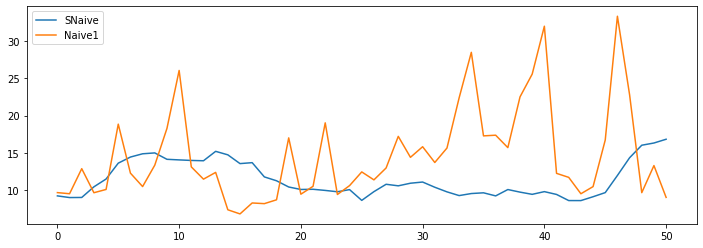

In [17]:
ax = pd.DataFrame(cv_scores_1).plot(figsize=(12,4))
pd.DataFrame(cv_scores_2).plot(ax=ax)
ax.legend(['SNaive', 'Naive1'])

In [18]:
model = SNaive(period=12)
model.fit(train)
preds = model.predict(horizon=12)

In [19]:
mean_absolute_error(test, preds)

15.130823489944726